In [1]:
from matplotlib.pyplot import cm
import numpy as np
import scipy.io as sio
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, InputLayer, Flatten, Conv2D,MaxPooling2D,Conv2DTranspose,LeakyReLU
from keras.utils.vis_utils import plot_model
import math
import pandas as pd
import matplotlib.gridspec as gridspec
import csv

In [2]:
#%% Define helper functions and initialize parameters
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / math.sqrt((a*a).sum() * (b*b).sum());
    return r

n = 7 # an odd number of digits to show in the figure
n_vals=[round(np.random.uniform()*100) for _ in range(n)]
train_inds_all=np.array([round(i) for i in np.linspace(0,59999,60000)])#to become indices of train/val later

In [3]:
#%% Load Data
Xtest_digits=np.transpose(sio.loadmat('Xtest_digits_mnist.mat')['Xtest_digits'].squeeze()).reshape([10000,28*28],order='F') 
Xtrain_digits=np.transpose(sio.loadmat('Xtrain_digits_mnist.mat')['Xtrain_digits'].squeeze()).reshape([60000,28*28],order='F')
outputTest_digits=np.transpose(sio.loadmat('outputTest_digits_mnist.mat')['outputTest_digits'].squeeze()).reshape([10000,28*28],order='F')
outputTrain_digits=np.transpose(sio.loadmat('outputTrain_digits_mnist.mat')['outputTrain_digits'].squeeze()).reshape([60000,28*28],order='F')
n_low_vec_test=sio.loadmat('n_low_vec_test.mat')['n_low_vec_test']
n_low_vec=sio.loadmat('n_low_vec_train.mat')['n_low_vec']
y_train_labels=sio.loadmat('mnist_train_labels.mat')['YTrain'] 

In [4]:
#%% Load values comparing RC, W, CS
test_digits_RC=np.transpose(sio.loadmat('test_digits_RC.mat')['test_digits_RC'].squeeze()).reshape([10000,28*28],order='F')
test_digits_CS=np.transpose(sio.loadmat('test_digits_CS.mat')['test_digits_CS'].squeeze()).reshape([10000,28*28],order='F')
test_digits_WRC=np.transpose(sio.loadmat('test_digits_WRC.mat')['test_digits_WRC'].squeeze()).reshape([10000,28*28],order='F')
test_digits_WCS=np.transpose(sio.loadmat('test_digits_WCS.mat')['test_digits_WCS'].squeeze()).reshape([10000,28*28],order='F')
n_low_vec_test_RC_CS_W=sio.loadmat('n_low_vec_test_RC_CS_W.mat')['n_low_vec_test']

In [5]:
#%% Load data made with CS
Xtrain_digits_cs=np.transpose(sio.loadmat('Xtrain_digits_mnist_CS.mat')['Xtrain_digits'].squeeze()).reshape([60000,28*28],order='F')
outputTrain_digits_cs=np.transpose(sio.loadmat('outputTrain_digits_mnist_CS.mat')['outputTrain_digits'].squeeze()).reshape([60000,28*28],order='F')
outputTest_digits_cs=np.transpose(sio.loadmat('outputTest_digits_mnist_CS.mat')['outputTest_digits'].squeeze()).reshape([10000,28*28],order='F')

In [6]:
#%% Load MNIST data
from keras.datasets import mnist
 
(MNIST_train_X, MNIST_train_y), (MNIST_test_X, MNIST_test_y) = mnist.load_data()
del MNIST_train_X, MNIST_train_y, MNIST_test_y

In [7]:
#Make smaller sets to train and validate on
X_train, X_val, output_digits_train, output_digits_val, train_inds_train, train_inds_val= train_test_split(Xtrain_digits, 
                                                    outputTrain_digits,train_inds_all,
                                                    stratify=y_train_labels, 
                                                    test_size=0.1666666, random_state=42)

X_train_train, X_train_val, output_digits_train_train, output_digits_train_val=train_test_split(X_train,output_digits_train,
                                                              stratify=y_train_labels[train_inds_train],
                                                              test_size=0.2, random_state=10)


X_train_cs, X_val_cs, output_digits_train_cs, output_digits_val_cs, train_inds_train_cs, train_inds_val_cs= train_test_split(Xtrain_digits_cs, 
                                                    outputTrain_digits_cs,train_inds_all,
                                                    stratify=y_train_labels, 
                                                    test_size=0.1666666, random_state=42)

X_train_train_cs, X_train_val_cs, output_digits_train_train_cs, output_digits_train_val_cs=train_test_split(X_train_cs,output_digits_train_cs,
                                                              stratify=y_train_labels[train_inds_train_cs],
                                                              test_size=0.2, random_state=10)

Convolutional Autoencoder Trained on RC

In [8]:
# Train the Autoencoder
coding_size=60
filter_size=11
kernel_size=101
pool_size=2
convpad='same'
poolpad='same'

def build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad):
    # # The encoder
    encoder = Sequential(name="Encoder")
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad, name="Covolutional_1"))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad, name="Pooling_1"))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad, name="Covolutional_2"))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad, name="Pooling_2"))
    encoder.add(Dense(coding_size,activation=LeakyReLU(), name="Coding"))

    # # The decoder
    decoder = Sequential(name="Decoder")
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad, name="Covolutional_Transpose_1"))
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad, name="Covolutional_Transpose_2"))
    decoder.add(Conv2D(1, (1,1), activation=LeakyReLU(), padding='same', name="Output"))

    return encoder, decoder    

encoder_rc, decoder_rc = build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad)

inpt=Input(shape=(28,28,1),name="Input")
code_rc = encoder_rc(inpt)
reconstruction_rc = decoder_rc(code_rc)
autoencoder_rc=Model(inpt,reconstruction_rc)
autoencoder_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_rc.summary())
#plot_model(autoencoder_rc, show_shapes=True, to_file='conv_autoencoder_RC.png',dpi=500,expand_nested=True)


filepath="best_model_convTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=0 #Set whether to train the network de novo or use the existing weights
if train_new==1:
    classify_model_trained_rc=autoencoder_rc.fit(X_train_train.reshape([len(X_train_train),28,28,1]),output_digits_train_train.reshape([len(X_train_train),28,28,1]),
                                                 validation_data=(X_train_val.reshape([len(X_train_val),28,28,1]), 
                                                 output_digits_train_val.reshape([len(X_train_val),28,28,1])),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_rc.load_weights(mc.filepath)
else:
    autoencoder_rc.load_weights(mc.filepath)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoder (Sequential)         (None, 7, 7, 60)          1347274   
_________________________________________________________________
Decoder (Sequential)         (None, 28, 28, 1)         7967015   
Total params: 9,314,289
Trainable params: 9,314,289
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#Generate network outputs

y_hat_convRC_test_digits_RC=autoencoder_rc.predict(test_digits_RC.reshape([10000,28,28,1])).squeeze()
y_hat_convRC_test_digits_CS=autoencoder_rc.predict(test_digits_CS.reshape([10000,28,28,1])).squeeze()
y_hat_convRC_test_digits_WRC=autoencoder_rc.predict(test_digits_WRC.reshape([10000,28,28,1])).squeeze()
y_hat_convRC_test_digits_WCS=autoencoder_rc.predict(test_digits_WCS.reshape([10000,28,28,1])).squeeze()

reconstructions_rcnet=[y_hat_convRC_test_digits_RC,y_hat_convRC_test_digits_WRC,
                 y_hat_convRC_test_digits_CS,y_hat_convRC_test_digits_WCS]

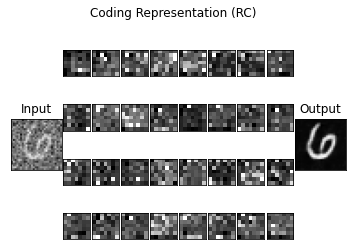

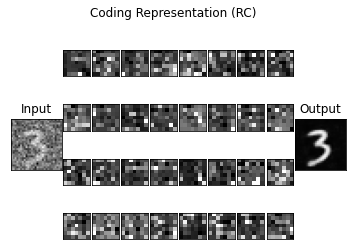

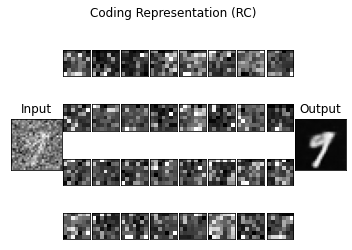

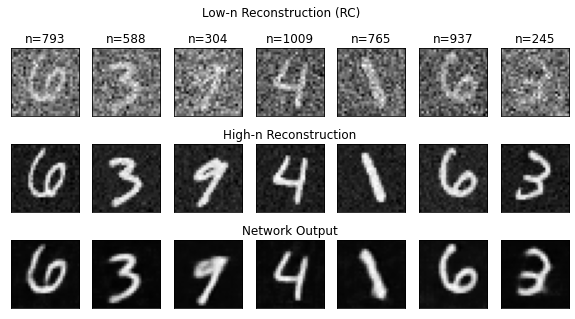

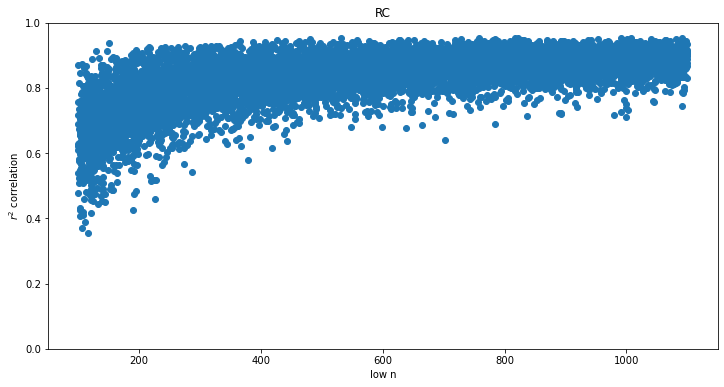

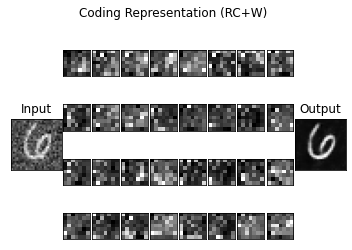

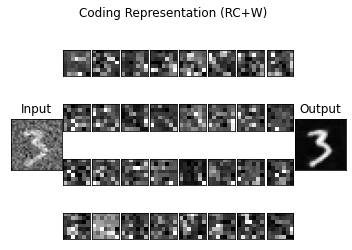

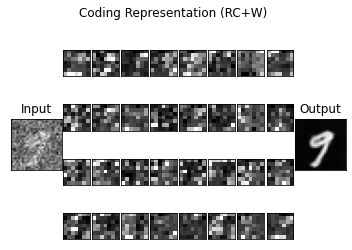

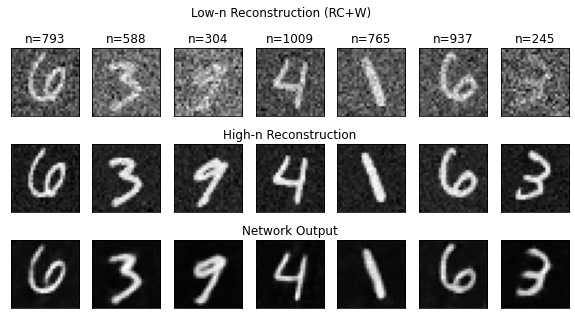

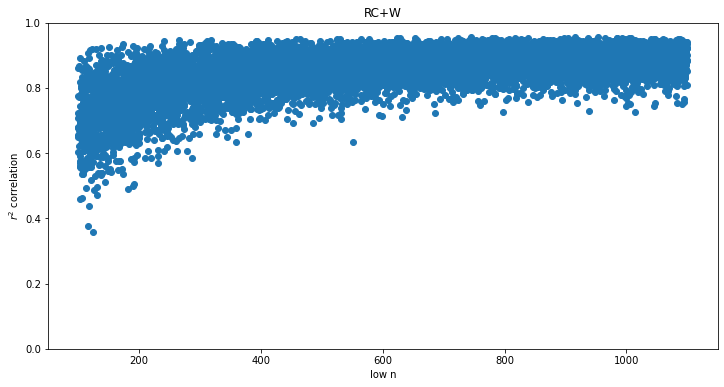

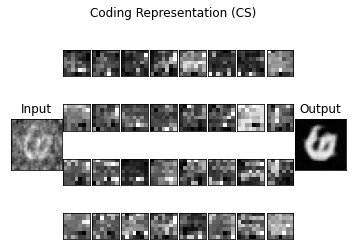

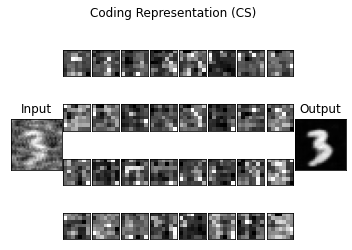

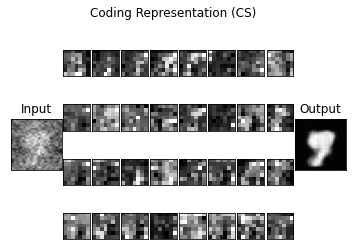

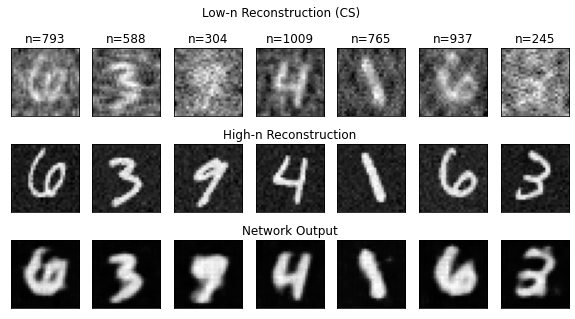

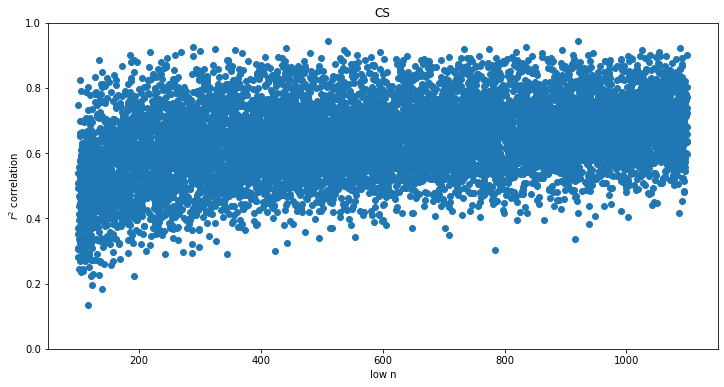

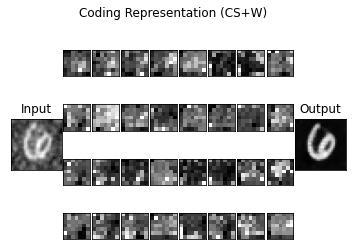

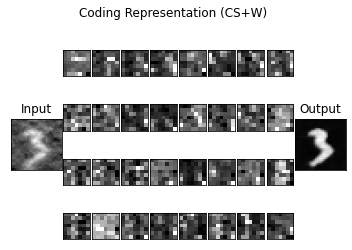

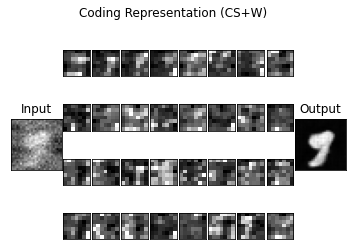

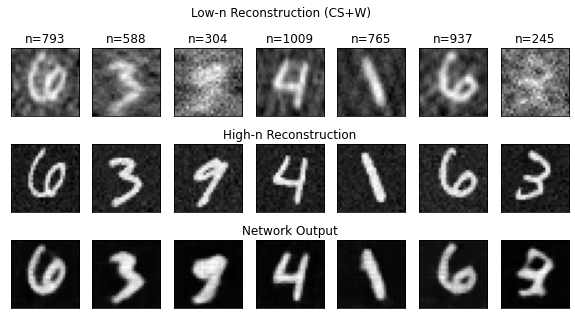

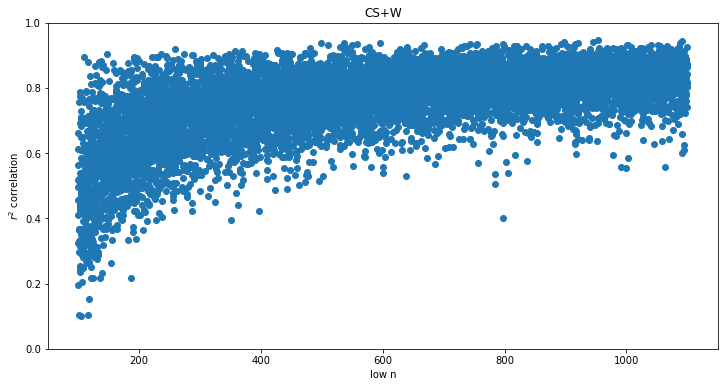

RC      0.835784
RC+W    0.844656
CS      0.638936
CS+W    0.759213
dtype: float64
RC      0.623925
RC+W    0.680246
CS      0.410150
CS+W    0.411716
dtype: float64
RC      0.890261
RC+W    0.886553
CS      0.708834
CS+W    0.841526
dtype: float64


In [10]:
#Make figures of the results

images=[test_digits_RC, test_digits_WRC,test_digits_CS,test_digits_WCS]   
titles=["RC","RC+W","CS","CS+W"] 

# Set which plots to plot
show_coding_layer=1 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=1 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder_rc.predict(images[recon_type].reshape([10000,28,28,1])).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])#4, 8, ii+1)
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits[i].reshape(28, 28),reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())    

<Figure size 432x288 with 0 Axes>

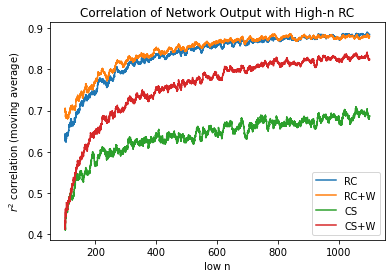

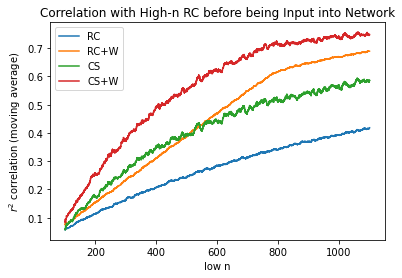

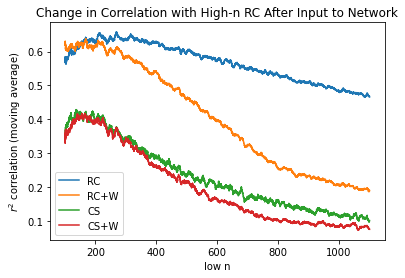

In [11]:
#Plot Correlations with high-n RC data
plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n RC")
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation with High-n RC before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Change in Correlation with High-n RC After Input to Network")
plt.show()

RC      0.860138
RC+W    0.869181
CS      0.657591
CS+W    0.781287
dtype: float64
RC      0.642578
RC+W    0.699581
CS      0.424458
CS+W    0.422787
dtype: float64
RC      0.915763
RC+W    0.911967
CS      0.729135
CS+W    0.865412
dtype: float64


<Figure size 432x288 with 0 Axes>

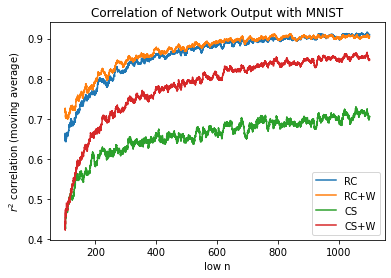

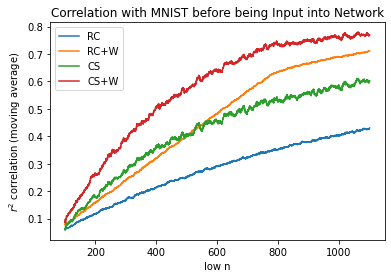

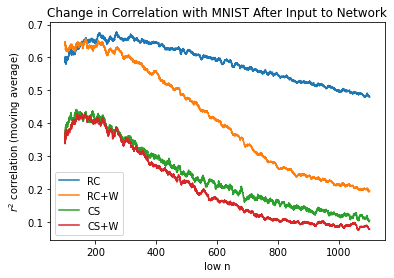

In [12]:
#Plot Correlations with MNIST digits

df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:],reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()

Convolutional Autoencoder Trained on CS

In [13]:
# Train the Autoencoder

coding_size=60
filter_size=11
kernel_size=101
pool_size=2
convpad='same'
poolpad='same'

def build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad):
    # # The encoder
    encoder = Sequential(name="Encoder")
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad, name="Covolutional_1"))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad, name="Pooling_1"))
    encoder.add(Conv2D(filter_size, kernel_size, activation=LeakyReLU(), padding=convpad, name="Covolutional_2"))
    encoder.add(MaxPooling2D(pool_size, padding=poolpad, name="Pooling_2"))
    encoder.add(Dense(coding_size,activation=LeakyReLU(), name="Coding"))

    # # The decoder
    decoder = Sequential(name="Decoder")
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad, name="Covolutional_Transpose_1"))
    decoder.add(Conv2DTranspose(filter_size, kernel_size, strides=2, activation=LeakyReLU(), padding=convpad, name="Covolutional_Transpose_2"))
    decoder.add(Conv2D(1, (1,1), activation=LeakyReLU(), padding='same', name="Output"))

    return encoder, decoder    



encoder, decoder = build_conv_autoencoder(filter_size, kernel_size, pool_size, coding_size,convpad,poolpad)

inpt=Input(shape=(28,28,1),name="Input")
code_cs = encoder(inpt)
reconstruction = decoder(code_cs)
autoencoder_cs=Model(inpt,reconstruction)
autoencoder_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_cs.summary())

filepath="best_model_convTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=0
if train_new==1:
    classify_model_trained_cs=autoencoder_cs.fit(X_train_train_cs.reshape([len(X_train_train_cs),28,28,1]),output_digits_train_train_cs.reshape([len(X_train_train_cs),28,28,1]),
                                                 validation_data=(X_train_val_cs.reshape([len(X_train_val_cs),28,28,1]), 
                                                 output_digits_train_val_cs.reshape([len(X_train_val_cs),28,28,1])),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_cs.history['val_loss'])+1
    epochs = len(classify_model_trained_cs.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_cs.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_cs.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_cs.load_weights(mc.filepath)
else:
    autoencoder_cs.load_weights(mc.filepath)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoder (Sequential)         (None, 7, 7, 60)          1347274   
_________________________________________________________________
Decoder (Sequential)         (None, 28, 28, 1)         7967015   
Total params: 9,314,289
Trainable params: 9,314,289
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
#Generate network outputs
y_hat_convCS_test_digits_RC=autoencoder_cs.predict(test_digits_RC.reshape([10000,28,28,1])).squeeze()
y_hat_convCS_test_digits_CS=autoencoder_cs.predict(test_digits_CS.reshape([10000,28,28,1])).squeeze()
y_hat_convCS_test_digits_WRC=autoencoder_cs.predict(test_digits_WRC.reshape([10000,28,28,1])).squeeze()
y_hat_convCS_test_digits_WCS=autoencoder_cs.predict(test_digits_WCS.reshape([10000,28,28,1])).squeeze()

reconstructions_csnet=[y_hat_convCS_test_digits_RC,y_hat_convCS_test_digits_WRC,
                 y_hat_convCS_test_digits_CS,y_hat_convCS_test_digits_WCS]

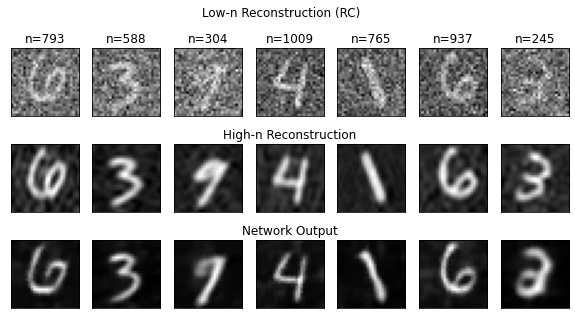

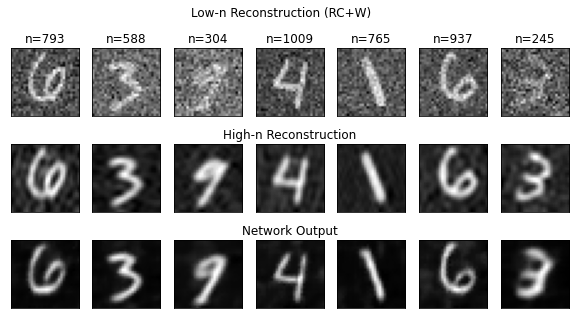

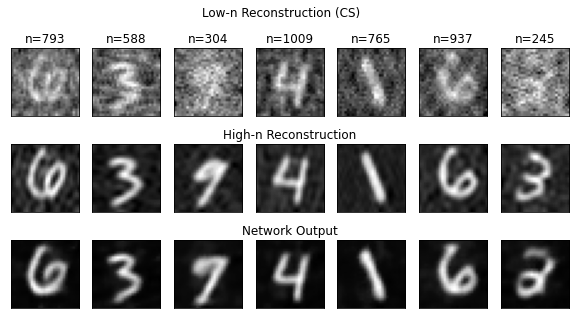

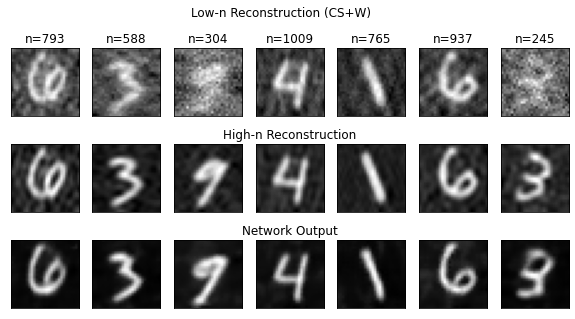

RC      0.824742
RC+W    0.849007
CS      0.856874
CS+W    0.872573
dtype: float64
RC      0.561172
RC+W    0.588967
CS      0.594630
CS+W    0.606421
dtype: float64
RC      0.874292
RC+W    0.892704
CS      0.916481
CS+W    0.914901
dtype: float64


In [15]:
#Make figures of the results

show_coding_layer=0 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=0 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder.predict(images[recon_type].reshape([10000,28,28,1])).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits_cs[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits_cs[i].reshape(28, 28),reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits_cs[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())    


<Figure size 432x288 with 0 Axes>

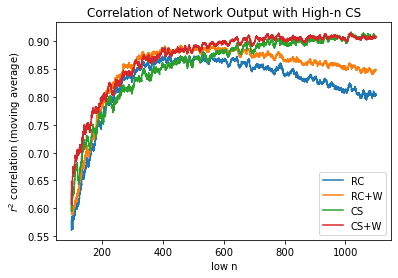

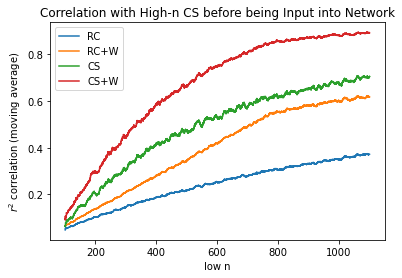

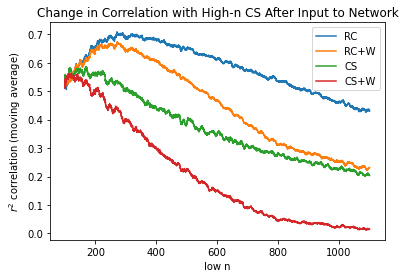

In [16]:
#Plot Correlations with high-n CS data
plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n CS")
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation with High-n CS before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Change in Correlation with High-n CS After Input to Network")
plt.show()

RC      0.770937
RC+W    0.796791
CS      0.758203
CS+W    0.796054
dtype: float64
RC      0.429728
RC+W    0.457979
CS      0.494403
CS+W    0.513846
dtype: float64
RC      0.837623
RC+W    0.860977
CS      0.830454
CS+W    0.858425
dtype: float64


<Figure size 432x288 with 0 Axes>

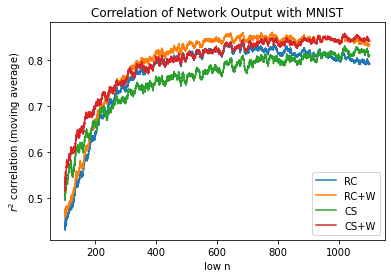

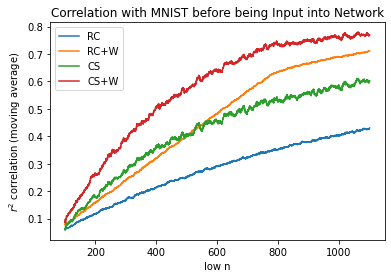

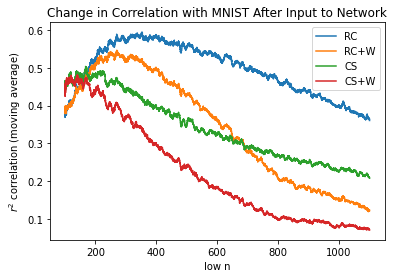

In [17]:
#Plot Correlations with MNIST digits
df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:],reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()

MLP Autoencoder Trained on RC

In [18]:
# Train the Autoencoder
dense_size=440
coding_size=120
def build_MLP_autoencoder(dense_size, coding_size):
    # The encoder
    encoder = Sequential(name="Encoder")
    encoder.add(InputLayer((784,),name="Encoder_Input"))
    encoder.add(Dense(dense_size,activation=LeakyReLU(),name="Encoding_Layer"))
    encoder.add(Dense(coding_size,activation=LeakyReLU(),name="Coding"))

    # The decoder
    decoder = Sequential(name="Decoder")
    decoder.add(InputLayer((coding_size,),name="Decoder_Input"))
    decoder.add(Dense(dense_size,activation=LeakyReLU(),name="Decoding_Layer"))
    decoder.add(Dense(784, activation=LeakyReLU(),name="Output"))
    return encoder, decoder


encoder_mlp_rc, decoder_mlp_rc = build_MLP_autoencoder(dense_size, coding_size)

inpt=Input((784,),name="Input")
code_rc = encoder_mlp_rc(inpt)
reconstruction_rc = decoder_mlp_rc(code_rc)
autoencoder_mlp_rc=Model(inpt,reconstruction_rc)
autoencoder_mlp_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_mlp_rc.summary())
plot_model(autoencoder_mlp_rc, show_shapes=True, to_file='mlp_autoencoder_RC.png',dpi=500,expand_nested=True)


filepath="best_model_mlpTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=0
if train_new==1:
    classify_model_trained_mlp_rc=autoencoder_mlp_rc.fit(X_train_train,output_digits_train_train,
                                                 validation_data=(X_train_val, 
                                                 output_digits_train_val),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    best_epoch=np.argmin(classify_model_trained_mlp_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_mlp_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_mlp_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_mlp_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_mlp_rc.load_weights(mc.filepath)
else:
    autoencoder_mlp_rc.load_weights(mc.filepath)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder (Sequential)         (None, 120)               398320    
_________________________________________________________________
Decoder (Sequential)         (None, 784)               398984    
Total params: 797,304
Trainable params: 797,304
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
#Generate network outputs
y_hat_mlpRC_test_digits_RC=autoencoder_mlp_rc.predict(test_digits_RC).squeeze()
y_hat_mlpRC_test_digits_CS=autoencoder_mlp_rc.predict(test_digits_CS).squeeze()
y_hat_mlpRC_test_digits_WRC=autoencoder_mlp_rc.predict(test_digits_WRC).squeeze()
y_hat_mlpRC_test_digits_WCS=autoencoder_mlp_rc.predict(test_digits_WCS).squeeze()

reconstructions_rcnet=[y_hat_mlpRC_test_digits_RC,y_hat_mlpRC_test_digits_WRC,
                 y_hat_mlpRC_test_digits_CS,y_hat_mlpRC_test_digits_WCS]

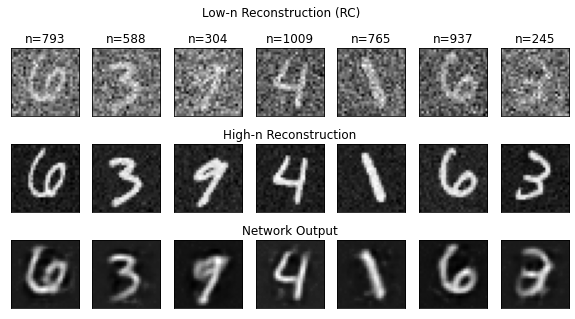

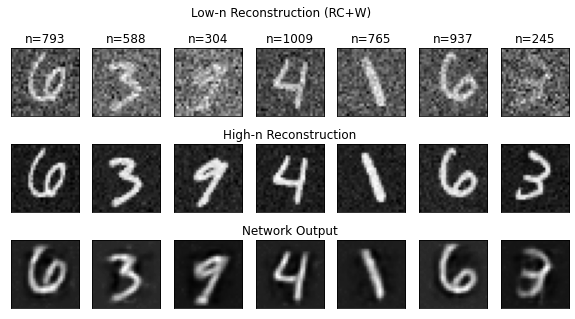

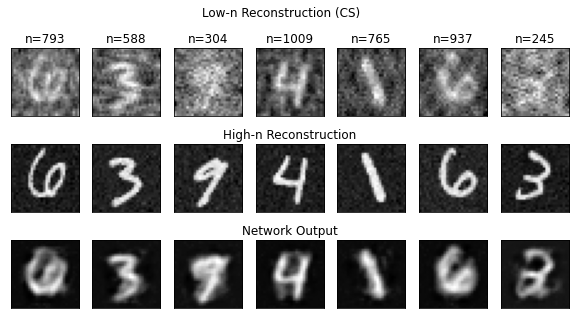

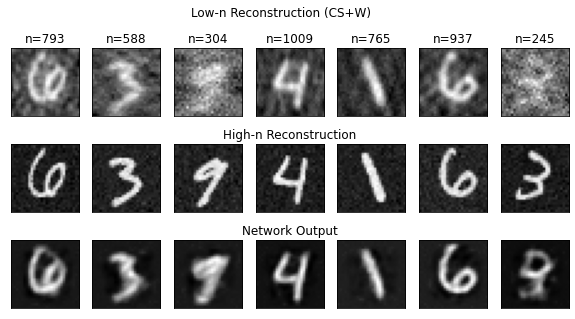

RC      0.794934
RC+W    0.812561
CS      0.657459
CS+W    0.758722
dtype: float64
RC      0.600607
RC+W    0.643337
CS      0.458118
CS+W    0.462840
dtype: float64
RC      0.846946
RC+W    0.854500
CS      0.730282
CS+W    0.833334
dtype: float64


In [20]:
#Make figures of the results

# Set which plots to plot
show_coding_layer=0 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=0 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder_mlp_rc.predict(images[recon_type]).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits[i],reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())

<Figure size 432x288 with 0 Axes>

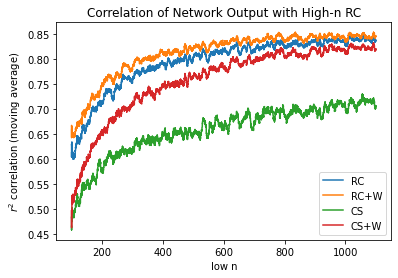

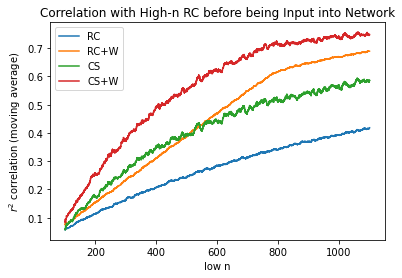

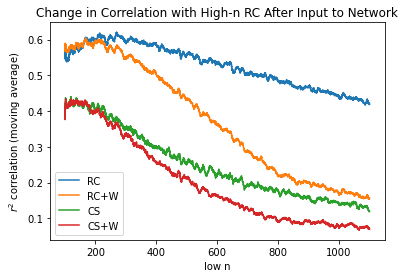

In [21]:
#Plot Correlations with high-n RC data
plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n RC")
# plt.ylim([0,1])
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with High-n RC before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with High-n RC After Input to Network")
plt.show()

RC      0.818120
RC+W    0.836211
CS      0.676673
CS+W    0.780821
dtype: float64
RC      0.618319
RC+W    0.661237
CS      0.473141
CS+W    0.476335
dtype: float64
RC      0.871203
RC+W    0.879085
CS      0.751222
CS+W    0.857183
dtype: float64


<Figure size 432x288 with 0 Axes>

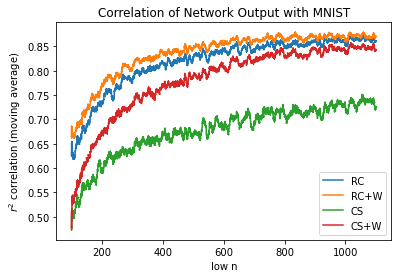

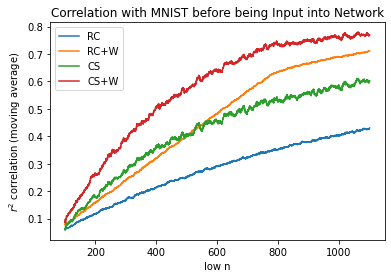

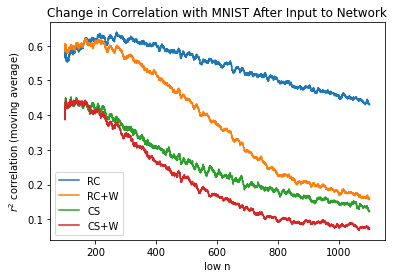

In [22]:
#Plot Correlations with MNIST digits
df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:].reshape(784,),reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
# plt.ylim([0,1])
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()

MLP Autoencoder Trained on CS

In [23]:
# Train the Autoencoder

dense_size=440
coding_size=120
def build_MLP_autoencoder(dense_size, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder


encoder_mlp_cs, decoder_mlp_cs = build_MLP_autoencoder(dense_size, coding_size)

inpt=Input((784,))
code_cs = encoder_mlp_cs(inpt)
reconstruction_cs = decoder_mlp_cs(code_cs)
autoencoder_mlp_cs=Model(inpt,reconstruction_cs)
autoencoder_mlp_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_mlp_cs.summary())
plot_model(autoencoder_mlp_cs, show_shapes=True, to_file='mlp_autoencoder_CS.png',expand_nested=True)


filepath="best_model_mlpTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=0
if train_new==1:
    classify_model_trained_mlp_cs=autoencoder_mlp_cs.fit(X_train_train_cs,output_digits_train_train_cs,
                                                 validation_data=(X_train_val_cs, 
                                                 output_digits_train_val_cs),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    best_epoch=np.argmin(classify_model_trained_mlp_cs.history['val_loss'])+1
    epochs = len(classify_model_trained_mlp_cs.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_mlp_cs.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_mlp_cs.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_mlp_cs.load_weights(mc.filepath)
else:
    autoencoder_mlp_cs.load_weights(mc.filepath)


Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 120)               398320    
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               398984    
Total params: 797,304
Trainable params: 797,304
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
#Generate network outputs

y_hat_mlpCS_test_digits_RC=autoencoder_mlp_cs.predict(test_digits_RC).squeeze()
y_hat_mlpCS_test_digits_CS=autoencoder_mlp_cs.predict(test_digits_CS).squeeze()
y_hat_mlpCS_test_digits_WRC=autoencoder_mlp_cs.predict(test_digits_WRC).squeeze()
y_hat_mlpCS_test_digits_WCS=autoencoder_mlp_cs.predict(test_digits_WCS).squeeze()

reconstructions_csnet=[y_hat_mlpCS_test_digits_RC,y_hat_mlpCS_test_digits_WRC,
                 y_hat_mlpCS_test_digits_CS,y_hat_mlpCS_test_digits_WCS]

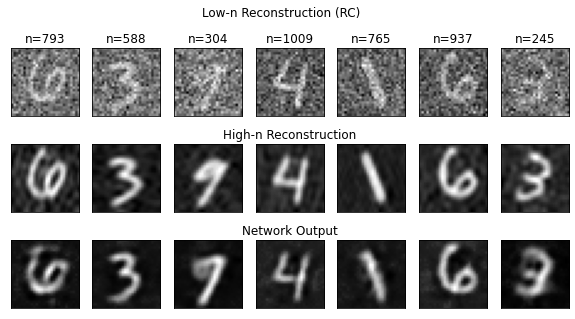

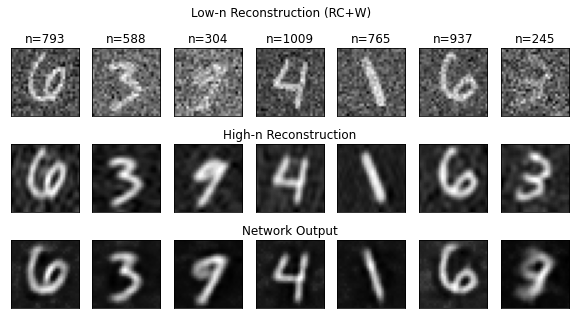

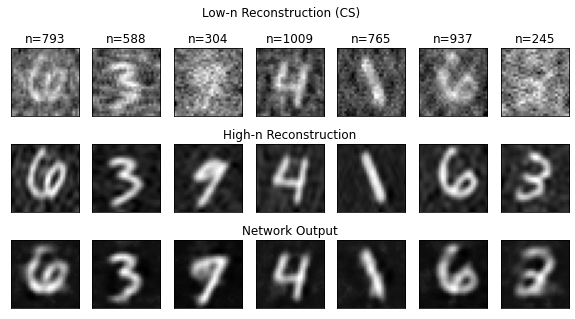

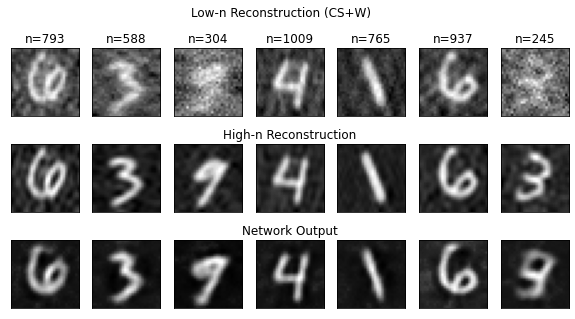

RC      0.807426
RC+W    0.827925
CS      0.831611
CS+W    0.853338
dtype: float64
RC      0.592948
RC+W    0.619765
CS      0.573634
CS+W    0.620010
dtype: float64
RC      0.859445
RC+W    0.872899
CS      0.894195
CS+W    0.896987
dtype: float64


In [25]:
#Make figures of the results

# Set which plots to plot
show_coding_layer=0 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=0 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder_mlp_cs.predict(images[recon_type]).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits_cs[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits_cs[i],reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits_cs[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())

<Figure size 432x288 with 0 Axes>

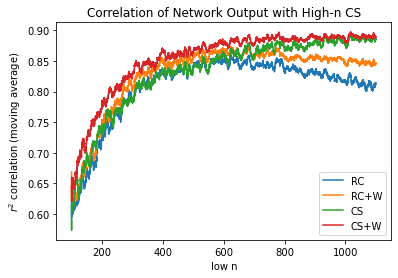

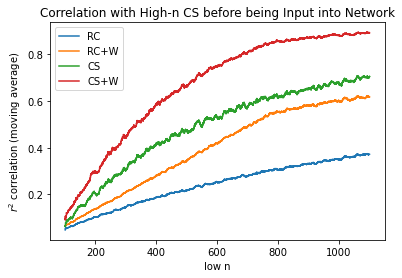

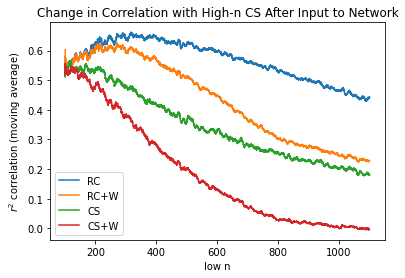

In [26]:
#Plot Correlations with high-n CS data

plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n CS")
# plt.ylim([0,1])
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with High-n CS before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with High-n CS After Input to Network")
plt.show()

RC      0.742921
RC+W    0.768106
CS      0.721154
CS+W    0.763420
dtype: float64
RC      0.473523
RC+W    0.502597
CS      0.469859
CS+W    0.524106
dtype: float64
RC      0.812715
RC+W    0.836028
CS      0.797357
CS+W    0.830521
dtype: float64


<Figure size 432x288 with 0 Axes>

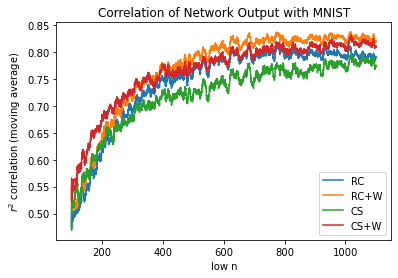

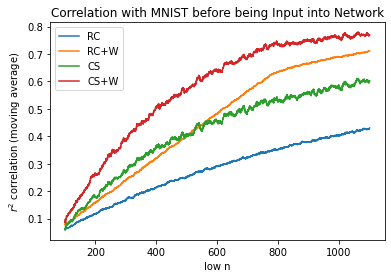

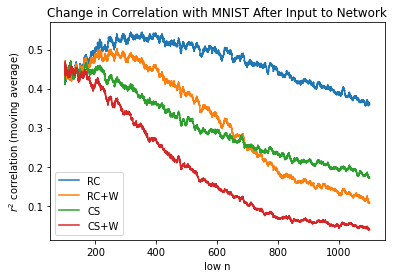

In [27]:
#Plot Correlations with MNIST digits
df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:].reshape(784,),reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
# plt.ylim([0,1])
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()

Deep Autoencoder Trained on RC

In [28]:
# Train the Autoencoder

dense_size_outer=480
dense_size_inner=460
coding_size=120
def build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size):
    # The encoder
    encoder = Sequential(name="Encoder")
    encoder.add(InputLayer((784,),name="Encoder_Input"))
    encoder.add(Dense(dense_size_outer,activation=LeakyReLU(),name="Encoder_Outer"))
    encoder.add(Dense(dense_size_inner,activation=LeakyReLU(),name="Encoder_Inner"))
    encoder.add(Dense(coding_size,activation=LeakyReLU(),name="Encoding"))

    # The decoder
    decoder = Sequential(name="Decoder")
    decoder.add(InputLayer((coding_size,),name="Decoder_Input"))
    decoder.add(Dense(dense_size_inner,activation=LeakyReLU(),name="Decoder_Inner"))
    decoder.add(Dense(dense_size_outer,activation=LeakyReLU(),name="Decoder_Outer"))
    decoder.add(Dense(784, activation=LeakyReLU(),name="Output"))
    return encoder, decoder

encoder_deep_mlp_rc, decoder_deep_mlp_rc = build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size)

inpt=Input((784,),name="Input")
code_rc = encoder_deep_mlp_rc(inpt)
reconstruction_rc = decoder_deep_mlp_rc(code_rc)
autoencoder_deep_mlp_rc=Model(inpt,reconstruction_rc)
autoencoder_deep_mlp_rc.compile(optimizer='adam', loss='mse')
print(autoencoder_deep_mlp_rc.summary())
plot_model(autoencoder_deep_mlp_rc, show_shapes=True, to_file='deep_mlp_autoencoder_RC.png',dpi=500,expand_nested=True)


filepath="best_model_deep_mlpTrained_on_RC.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]

train_new=0
if train_new==1:
    classify_model_trained_deep_mlp_rc=autoencoder_deep_mlp_rc.fit(X_train_train,output_digits_train_train,
                                                 validation_data=(X_train_val, output_digits_train_val),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    
    best_epoch=np.argmin(classify_model_trained_deep_mlp_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_deep_mlp_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_deep_mlp_rc.load_weights(mc.filepath)
else:
    autoencoder_deep_mlp_rc.load_weights(mc.filepath)

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder (Sequential)         (None, 120)               653380    
_________________________________________________________________
Decoder (Sequential)         (None, 784)               654044    
Total params: 1,307,424
Trainable params: 1,307,424
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
#Generate network outputs

y_hat_deepRC_test_digits_RC=autoencoder_deep_mlp_rc.predict(test_digits_RC).squeeze()
y_hat_deepRC_test_digits_CS=autoencoder_deep_mlp_rc.predict(test_digits_CS).squeeze()
y_hat_deepRC_test_digits_WRC=autoencoder_deep_mlp_rc.predict(test_digits_WRC).squeeze()
y_hat_deepRC_test_digits_WCS=autoencoder_deep_mlp_rc.predict(test_digits_WCS).squeeze()

reconstructions_rcnet=[y_hat_deepRC_test_digits_RC,y_hat_deepRC_test_digits_WRC,
                 y_hat_deepRC_test_digits_CS,y_hat_deepRC_test_digits_WCS]

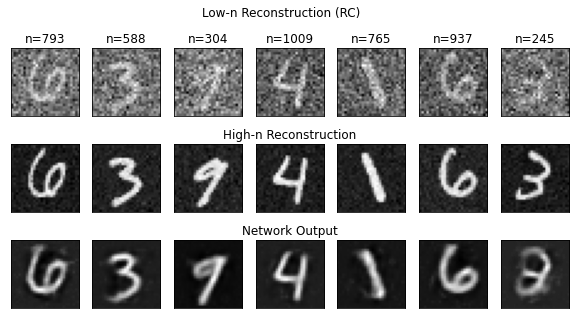

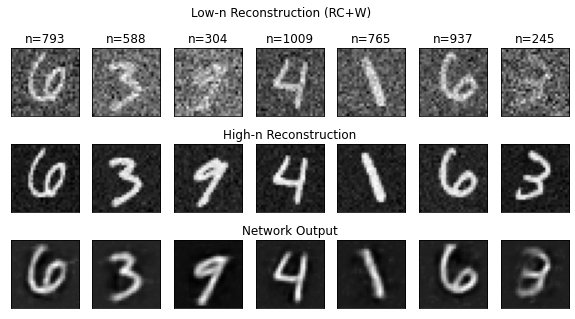

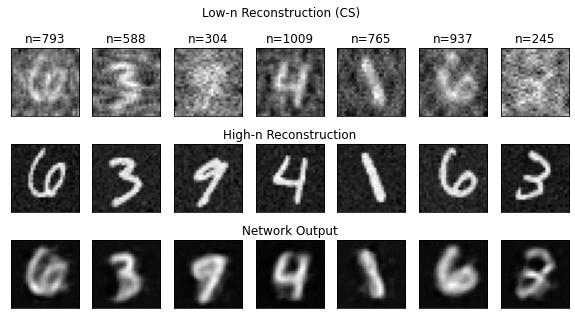

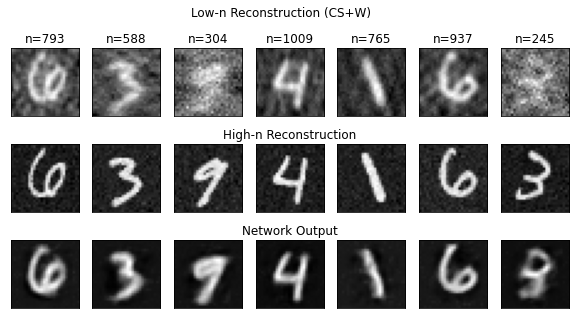

RC      0.796097
RC+W    0.811661
CS      0.663489
CS+W    0.757301
dtype: float64
RC      0.608868
RC+W    0.646947
CS      0.434833
CS+W    0.452333
dtype: float64
RC      0.846261
RC+W    0.851714
CS      0.733282
CS+W    0.830000
dtype: float64


In [30]:
#Make figures of the results

# Set which plots to plot
show_coding_layer=0 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=0 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder_deep_mlp_rc.predict(images[recon_type]).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])#4, 8, ii+1)
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_rcnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits[i],reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())

<Figure size 432x288 with 0 Axes>

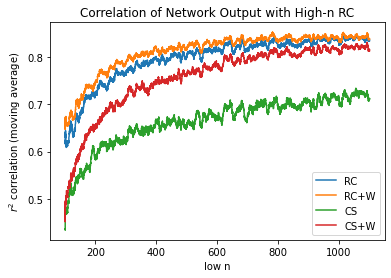

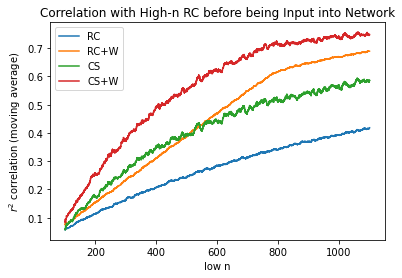

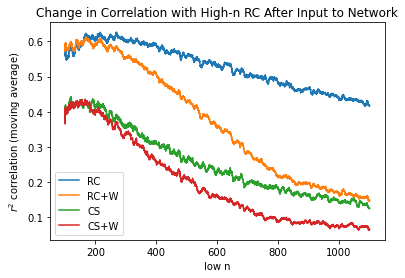

In [31]:
#Plot Correlations with high-n RC data

plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n RC")
# plt.ylim([0,1])
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with High-n RC before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with High-n RC After Input to Network")
plt.show()

RC      0.819362
RC+W    0.835281
CS      0.682900
CS+W    0.779344
dtype: float64
RC      0.627761
RC+W    0.665483
CS      0.448372
CS+W    0.463246
dtype: float64
RC      0.870783
RC+W    0.876065
CS      0.754545
CS+W    0.853688
dtype: float64


<Figure size 432x288 with 0 Axes>

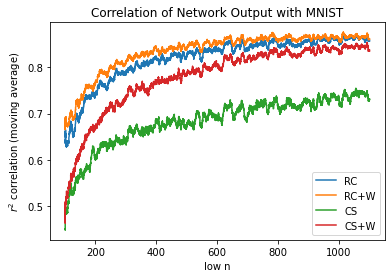

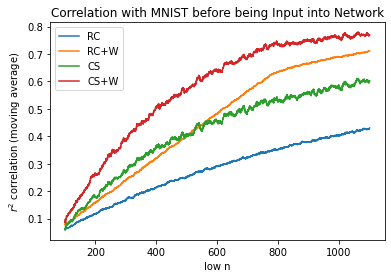

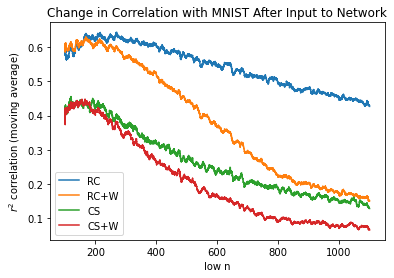

In [32]:
#Plot Correlations with MNIST digits

df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:].reshape(784,),reconstructions_rcnet[recon_type][i])**2 for i in range(len(reconstructions_rcnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
# plt.ylim([0,1])
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()

Deep Autoencoder Trained on CS

In [33]:
# Train the Autoencoder

dense_size_outer=480
dense_size_inner=460
coding_size=120
def build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer((784,)))
    encoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    encoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    encoder.add(Dense(coding_size,activation=LeakyReLU()))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((coding_size,)))
    decoder.add(Dense(dense_size_inner,activation=LeakyReLU()))
    decoder.add(Dense(dense_size_outer,activation=LeakyReLU()))
    decoder.add(Dense(784, activation=LeakyReLU()))
    return encoder, decoder

encoder_deep_mlp_cs, decoder_deep_mlp_cs = build_deep_autoencoder(dense_size_outer, dense_size_inner, coding_size)

inpt=Input((784,))
code_cs = encoder_deep_mlp_cs(inpt)
reconstruction_cs = decoder_deep_mlp_cs(code_cs)
autoencoder_deep_mlp_cs=Model(inpt,reconstruction_cs)
autoencoder_deep_mlp_cs.compile(optimizer='adam', loss='mse')
print(autoencoder_deep_mlp_cs.summary())
plot_model(autoencoder_deep_mlp_cs, show_shapes=True, to_file='deep_mlp_autoencoder_CS.png',expand_nested=True)


filepath="best_model_deep_mlpTrained_on_CS.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss',verbose=0,min_delta=0.01,patience=5)
callbacks=[es, mc]


train_new=0
if train_new==1:
    classify_model_trained_deep_mlp_rc=autoencoder_deep_mlp_cs.fit(X_train_train_cs,output_digits_train_train_cs,
                                                 validation_data=(X_train_val_cs, 
                                                 output_digits_train_val_cs),
                                                 epochs=70,verbose=2,callbacks=callbacks)
    best_epoch=np.argmin(classify_model_trained_deep_mlp_rc.history['val_loss'])+1
    epochs = len(classify_model_trained_deep_mlp_rc.history['loss'])
    
    makeTrainingPlot=1
    if makeTrainingPlot==1: #Make a plot of training progress
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['loss'], label='train')
        plt.plot(range(epochs),classify_model_trained_deep_mlp_rc.history['val_loss'],label='validation')
        plt.xlabel('Epochs')
        plt.ylabel("Categorical Crossentropy")
        plt.title('Model Performance')
        plt.legend()
        plt.show()
    autoencoder_deep_mlp_cs.load_weights(mc.filepath)
else:
    autoencoder_deep_mlp_cs.load_weights(mc.filepath)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 120)               653380    
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               654044    
Total params: 1,307,424
Trainable params: 1,307,424
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
#Generate network outputs

y_hat_deepCS_test_digits_RC=autoencoder_deep_mlp_cs.predict(test_digits_RC).squeeze()
y_hat_deepCS_test_digits_CS=autoencoder_deep_mlp_cs.predict(test_digits_CS).squeeze()
y_hat_deepCS_test_digits_WRC=autoencoder_deep_mlp_cs.predict(test_digits_WRC).squeeze()
y_hat_deepCS_test_digits_WCS=autoencoder_deep_mlp_cs.predict(test_digits_WCS).squeeze()

reconstructions_csnet=[y_hat_deepCS_test_digits_RC,y_hat_deepCS_test_digits_WRC,
                 y_hat_deepCS_test_digits_CS,y_hat_deepCS_test_digits_WCS]

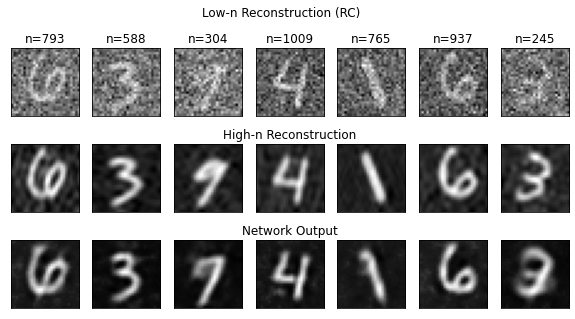

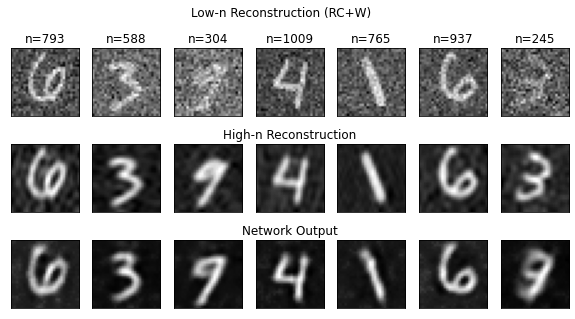

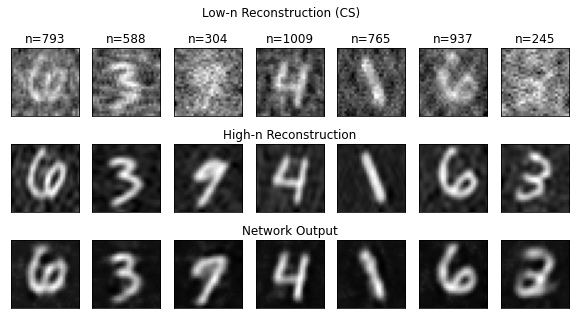

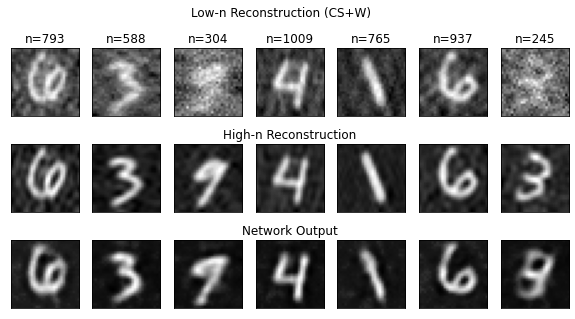

RC      0.814515
RC+W    0.832179
CS      0.830697
CS+W    0.852948
dtype: float64
RC      0.598593
RC+W    0.622313
CS      0.599391
CS+W    0.622177
dtype: float64
RC      0.864729
RC+W    0.875692
CS      0.889930
CS+W    0.897510
dtype: float64


In [35]:
#Make figures of the results

# Set which plots to plot
show_coding_layer=0 #whether to plot the representation of the coding
show_reconstructions=1 #Whether to plot the low-n, high-n and network output reconstructions
show_corr_scatter=0 #whether to plot correlation scatter plot over all n values

df_corr=pd.DataFrame()
df_corr_preNetwork=pd.DataFrame()
for recon_type in range(4):
    if show_coding_layer==1:
        encoding=encoder_deep_mlp_cs.predict(images[recon_type]).squeeze()
        for i in range(n-4):
            n_current=n_vals[i]
    
            fig = plt.figure()
            plt.gray()
            outer = gridspec.GridSpec(3, 32, wspace=0.2, hspace=0.2)
            n_current=n_vals[i]
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:,:5], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[:])
            ax.imshow(images[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Input")
            fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(4,8,
                               subplot_spec=outer[:3,5:27], wspace=0.1, hspace=0)
            for ii in range(32):
                      ax = plt.Subplot(fig,inner[ii])
                      ax.imshow(encoding[n_current,:,:,ii])
                      plt.gray()
                      ax.get_xaxis().set_visible(False)
                      ax.get_yaxis().set_visible(False)
                      fig.add_subplot(ax)
            inner = gridspec.GridSpecFromSubplotSpec(1,1,
                               subplot_spec=outer[:3,27:], wspace=0.1, hspace=0.1)
            ax = plt.Subplot(fig, inner[0])
            ax.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title("Output")
            fig.add_subplot(ax)    
            plt.suptitle('Coding Representation (%s)' % titles[recon_type])
            plt.show()
            
    if show_reconstructions==1:
        plt.figure(figsize=(10, 5))
        for i in range(n):
            n_current=n_vals[i]
            # plot original image
            ax = plt.subplot(3, n, i + 1)
            plt.imshow(images[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_title('n=%s'%n_low_vec_test_RC_CS_W[n_current][0])
        
            # plot high-n image 
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(outputTest_digits_cs[n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('High-n Reconstruction')
                
            # plot output image 
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(reconstructions_csnet[recon_type][n_current].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == (n-1)/2:
                ax.set_title('Network Output')
        plt.suptitle('Low-n Reconstruction (%s)' % titles[recon_type])        
        plt.show()
    
    correlations_squared=[corr2(outputTest_digits_cs[i],reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(outputTest_digits_cs[i],images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    if show_corr_scatter==1:
        plt.figure(figsize=(12, 6))
        plt.scatter(n_low_vec_test_RC_CS_W,correlations_squared)
        plt.xlabel("low n")
        plt.ylabel(r"$r^2$ correlation")
        plt.title(titles[recon_type])
        plt.ylim([0,1])
        plt.show()
    df_corr[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr.mean())
print(df_corr.min())
print(df_corr.max())

<Figure size 432x288 with 0 Axes>

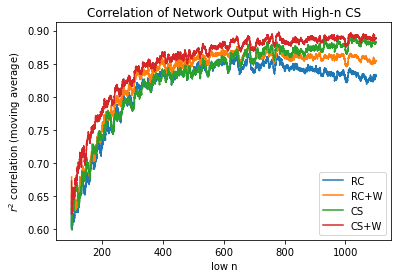

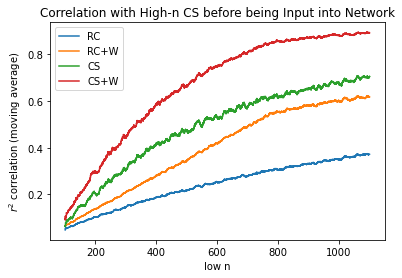

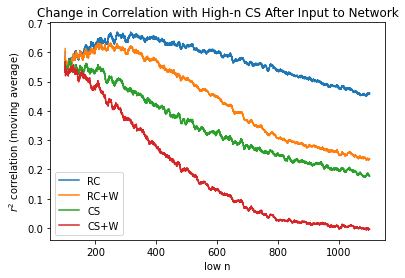

In [36]:
#Plot Correlations with high-n CS data

plt.figure()
df_corr.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with High-n CS")
# plt.ylim([0,1])
plt.show()

df_corr_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with High-n CS before being Input into Network")
plt.show()

(df_corr-df_corr_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with High-n CS After Input to Network")
plt.show()

RC      0.741050
RC+W    0.763182
CS      0.718749
CS+W    0.757887
dtype: float64
RC      0.485109
RC+W    0.507550
CS      0.493645
CS+W    0.528119
dtype: float64
RC      0.809403
RC+W    0.831817
CS      0.790762
CS+W    0.822182
dtype: float64


<Figure size 432x288 with 0 Axes>

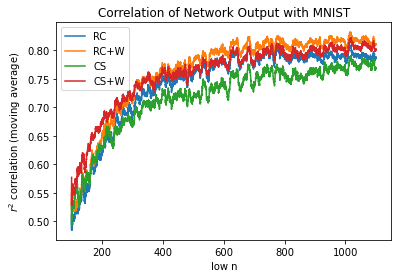

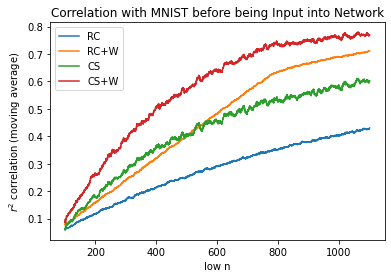

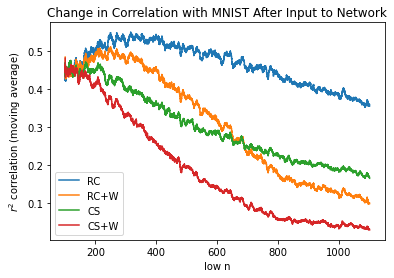

In [37]:
#Plot Correlations with MNIST digits

df_corr_mnist=pd.DataFrame()
df_corr_mnist_preNetwork=pd.DataFrame()
for recon_type in range(4):
    correlations_squared=[corr2(MNIST_test_X[i,:,:].reshape(784,),reconstructions_csnet[recon_type][i])**2 for i in range(len(reconstructions_csnet[recon_type]))]
    correlations_squared_preNetwork=[corr2(MNIST_test_X[i,:,:].reshape(784,),images[recon_type][i])**2 for i in range(len(images[recon_type]))]
    
    df_corr_mnist[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
    df_corr_mnist_preNetwork[titles[recon_type]]=pd.DataFrame(index=n_low_vec_test_RC_CS_W.squeeze(),data=correlations_squared_preNetwork).sort_index().iloc[:,0].rolling(100, min_periods=10).mean()
print(df_corr_mnist.mean())
print(df_corr_mnist.min())
print(df_corr_mnist.max())

plt.figure()
df_corr_mnist.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
plt.title("Correlation of Network Output with MNIST")
# plt.ylim([0,1])
plt.show()

df_corr_mnist_preNetwork.plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Correlation with MNIST before being Input into Network")
plt.show()

(df_corr_mnist-df_corr_mnist_preNetwork).plot()
plt.xlabel("low n")
plt.ylabel(r"$r^2$ correlation (moving average)")
# plt.ylim([0,1])
plt.title("Change in Correlation with MNIST After Input to Network")
plt.show()